In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import trange
import matplotlib.pyplot as plt

from mezo import MeZO

/raid/poggio/home/cheungb/miniconda3/envs/mezoenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
batch_size = 64
hidden_dim = 16

def make_model():
    torch.manual_seed(0)
    return nn.Linear(hidden_dim, hidden_dim)


def benchmark_train(model, opt, train_iter=1000):
    torch.manual_seed(0)
    inputs  = torch.randn(batch_size, hidden_dim)
    targets = torch.randn(batch_size, hidden_dim)

    def closure(with_backward=False):
        opt.zero_grad()
        outputs = model(inputs)
        loss = 0.5 * (targets - outputs).pow(2).mean()
        if with_backward:
            loss.backward()
        return loss

    losses = []
    for _ in (pbar:=trange(train_iter)):
        loss = opt.step(lambda: closure(with_backward=not isinstance(opt, MeZO)))
        pbar.set_description(f'{loss:.3f}')
        losses.append(loss.item())
    return losses


model = make_model()
opt = torch.optim.SGD(model.parameters(), lr=0.1)
sgd_losses = benchmark_train(model, opt)

model = make_model()
opt = MeZO(torch.optim.SGD(model.parameters(), lr=0.05), eps=1e-3) 
sgd_mezo_losses = benchmark_train(model, opt)

model = make_model()
opt = torch.optim.AdamW(model.parameters(), lr=0.1)
adam_losses = benchmark_train(model, opt)

model = make_model()
opt = MeZO(torch.optim.AdamW(model.parameters(), lr=0.005), eps=1e-3)  
adam_mezo_losses = benchmark_train(model, opt)

0.401: 100%|██████████| 1000/1000 [00:02<00:00, 381.32it/s]


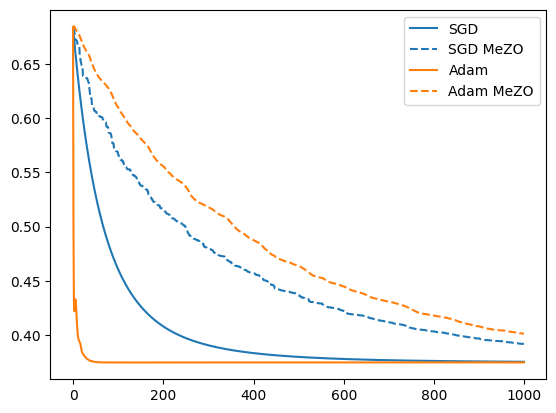

In [5]:
plt.figure()
plt.plot(sgd_losses, label='SGD', color='C0', linestyle='-')
plt.plot(sgd_mezo_losses, label='SGD MeZO', color='C0', linestyle='--')
plt.plot(adam_losses, label='Adam', color='C1', linestyle='-')
plt.plot(adam_mezo_losses, label='Adam MeZO', color='C1', linestyle='--')
plt.legend()
plt.show()